# SAS and R Integration for Machine Learning 

This notebook represents an example of how you can use SAS Viya with R for analysis.In this example, we will import R packages, start a CAS Session, load data from the local file system into CAS, explore the data, impute missing values, create several models in R, create several models in CAS, score a test set using our models, and assess model performance. <br> 
Further documentation on using SWAT with R can be found here: 
* [Getting Started with SAS Viya for R](https://go.documentation.sas.com/?cdcId=pgmcdc&cdcVersion=8.11&docsetId=caspg3r&docsetTarget=n0r11es31sftt2n19xherqhc44tj.htm&locale=en)
* [Package Swat](https://developer.sas.com/apis/swat/r/v1.0.0/R-swat.pdf)
***

## Table of Contents
1. [Scripting Wrapper for Analytics Transfer](#Scripting-Wrapper-for-Analytics-Transfer)
1. [Set Up the R Notebook for Analysis](#Set-Up-the-R-Notebook-for-Analysis) 
1. [Explore the Data](#Explore-the-Data)
1. [Clean the Data](#Clean-the-Data)
1. [Build and Score R Models](#Build-and-Score-R-Models)
1. [Build and Score CAS Models](#Build-and-Score-CAS-Models)
1. [Assess Models](#Assess-Models)
***

## Scripting Wrapper for Analytics Transfer

The SAS Scripting Wrapper for Analytics Transfer (SWAT) package for R is a R interface to SAS Cloud Analytic Services (CAS) which is the centerpiece of the SAS Viya framework. With this package, you can load data into memory and apply CAS actions to transform, summarize, model and score the data. Result tables from the actions are a superclass of data frame, enabling you to apply your existing R programming skills to further post-process CAS result tables.
***

## Set Up the R Notebook for Analysis

First, we will load the packages we want to use. 

In [1]:
# Load necessary packages
library('swat')
library('ggplot2')
library('reshape2')
library('rpart')
library('randomForest')
library('xgboost')
options(cas.print.messages = FALSE)
options(warn=-1)
sink()

SWAT 1.4.0
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin



Now we can create our connection to CAS. Please see [this documentation on connecting and starting CAS Sessions]( http://go.documentation.sas.com/?cdcId=vdmmlcdc&cdcVersion=8.11&docsetId=caspg3r&docsetTarget=p0paczu3x2qu0wn1p94ees7y5ls8.htm&locale=en) for more information. 

In [2]:
conn <- CAS('localhost', port=5570, caslib = 'casuser')

NOTE: Connecting to CAS and generating CAS action functions for loaded
      action sets...
NOTE: To generate the functions with signatures (for tab completion), set 
      options(cas.gen.function.sig=TRUE).


Next, we need to load our CAS Action Sets. Please see [this documentation on running CAS Actions](http://go.documentation.sas.com/?cdcId=vdmmlcdc&cdcVersion=8.11&docsetId=caspg3r&docsetTarget=p11zy53gvlofvsn1glguw9vuuhru.htm&locale=en) for more information. 

In [3]:
actionsets <- c('sampling', 'fedsql', 'decisionTree', 'percentile', 'autotune', 'regression')
for(i in actionsets){
    loadActionSet(conn, i)
}

Finally, we can load our data from a CSV file. 

In [4]:
castbl <- cas.read.csv(conn, './data/hmeq.csv')

***

## Explore the Data

Let us begin exploring our data. Just like in R, we can view the first few rows of our CAS data table using the head function. 

In [5]:
head(castbl)

BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1100,25860,39025,HomeImp,Other,10.5,0,0,94.36667,1,9,NaN
1,1300,70053,68400,HomeImp,Other,7.0,0,2,121.83333,0,14,NaN
1,1500,13500,16700,HomeImp,Other,4.0,0,0,149.46667,1,10,NaN
1,1500,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1700,97800,112000,HomeImp,Office,3.0,0,0,93.33333,0,14,NaN
1,1700,30548,40320,HomeImp,Other,9.0,0,0,101.46600,1,8,37.11361


Visual exploration helps us better understand patterns and distributions within our data. We can use ggplot to look at our data distributions. 

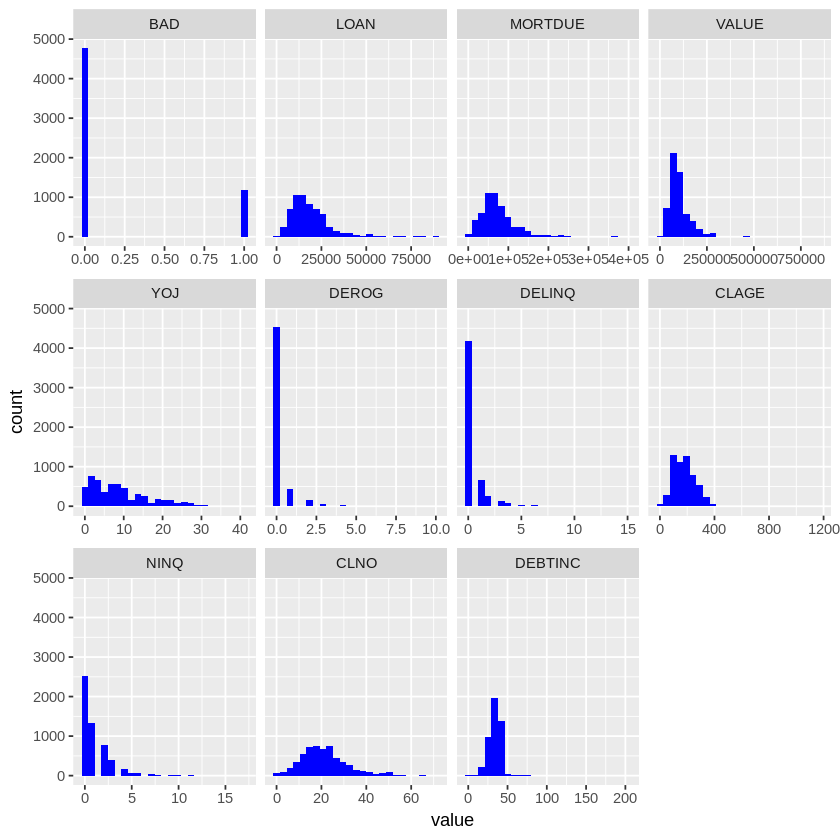

In [6]:
# Bring data locally
df <- to.casDataFrame(castbl, obs = nrow(castbl))
# Use reshape2's melt to help with data formatting
d <- melt(df[sapply(df, is.numeric)], id.vars=NULL)
ggplot(d, aes(x = value)) +
    facet_wrap(~variable,scales = 'free_x') +
    geom_histogram(fill = 'blue', bins = 25)

From our plots above, we can see that most of our home equity loans are _not bad_, meaning that they must be good. We can also see that most of our variables have a slight right skew. Let’s keep exploring our data by checking the missing values. 

In [7]:
# Get the number of missing values for all variables
tbl <- cas.simple.distinct(castbl)$Distinct[,c('Column', 'NMiss')]
tbl

Column,NMiss
<chr>,<dbl>
BAD,0
LOAN,0
MORTDUE,518
VALUE,112
REASON,252
JOB,279
YOJ,515
DEROG,708
DELINQ,580


In [8]:
# Easy way to get missing values for numeric variables
cas.nmiss(castbl)

BAD    LOAN MORTDUE   VALUE     YOJ   DEROG  DELINQ   CLAGE    NINQ    CLNO 
      0       0     518     112     515     708     580     308     510     222 
DEBTINC 
   1267

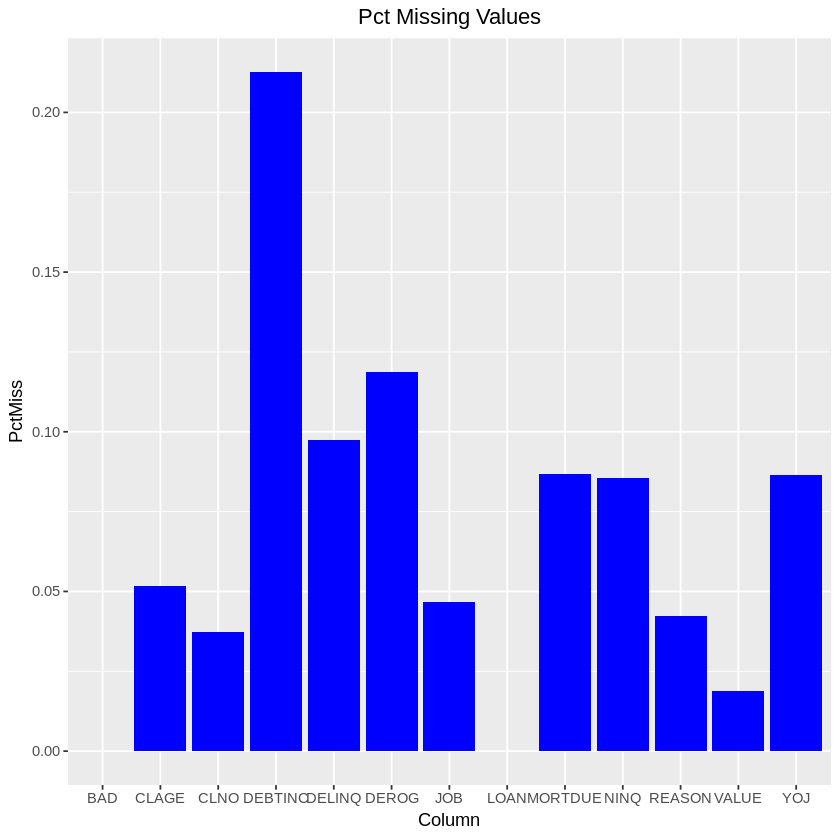

In [9]:
# Visualize the missing data
tbl$PctMiss <- tbl$NMiss/nrow(castbl)
ggplot(tbl, aes(Column, PctMiss)) +
    geom_col(fill = 'blue') +
    ggtitle('Pct Missing Values') +
    theme(plot.title = element_text(hjust = 0.5))

Using both R and SWAT, we have explored our data, and now we have an idea of what to look for when we clean our data. 

***

## Clean the Data

First, we should impute those missing values. 

In [10]:
# Impute missing values
cas.dataPreprocess.impute(castbl,
    methodContinuous = 'MEDIAN',
    methodNominal = 'MODE',
    inputs = colnames(castbl)[-1],
    copyAllVars = TRUE,
    casOut = list(name = 'hmeq', 
                replace = TRUE)
)

Variable,ImputeTech,ResultVar,N,NMiss,ImputedValueContinuous,ImputedValueNominal
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
LOAN,Median,IMP_LOAN,5960,0,16300.00000,
MORTDUE,Median,IMP_MORTDUE,5442,518,65019.00000,
VALUE,Median,IMP_VALUE,5848,112,89235.50000,
REASON,Mode,IMP_REASON,5708,252,NaN,DebtCon
JOB,Mode,IMP_JOB,5681,279,NaN,Other
YOJ,Median,IMP_YOJ,5445,515,7.00000,
DEROG,Median,IMP_DEROG,5252,708,0.00000,
DELINQ,Median,IMP_DELINQ,5380,580,0.00000,
CLAGE,Median,IMP_CLAGE,5652,308,173.46667,


Now, we should partition our data into training and testing sets. 

In [11]:
# Partition the data
cas.sampling.srs(conn,
    table = 'hmeq',
    samppct = 30,
    partind = TRUE,
    output = list(casOut = list(name = 'hmeq', replace = T), copyVars = 'ALL')
)

$outputSize
$outputSize$outputNObs
[1] 5960

$outputSize$outputNVars
[1] 26


$SRSFreq
  NObs NSamp
1 5960  1788

$OutputCasTables
              casLib Name Label Rows Columns
1 CASUSER(sasdemo05) hmeq       5960      26

Finally, let’s map our variables to build reusable labels for our function calls. 

In [12]:
#Note: I do not want to hard code any of my variable names.
indata <- 'hmeq'

# Get variable info and types
colinfo <- head(cas.table.columnInfo(conn, table = indata)$ColumnInfo, -1)

# My target variable is the first column
target <- colinfo$Column[1]

# For models that can inherently handle missing values (ex: Decision Tree)
inputs <- colinfo$Column[-1]
nominals <- c(target, subset(colinfo, Type == 'varchar')$Column)

# For models that can't handle missing values
imp_inputs =  c("IMP_CLAGE", "IMP_CLNO", "IMP_DEBTINC", "IMP_DELINQ",  
                   "IMP_DEROG", "IMP_LOAN", "IMP_MORTDUE", "IMP_NINQ", "IMP_VALUE", 
                   "IMP_YOJ", "IMP_JOB", "IMP_REASON")
imp_nominals = c("IMP_JOB", "IMP_REASON")

***

## Build and Score R Models

To run R models, the data must be taken from the in-memory CAS table and placed into a R data frame.

In [13]:
# Connect to in-memory CAS table
hmeq1 <- defCasTable(conn, tablename="HMEQ")

In [14]:
# Create CAS DataFrame from CAS table
df1 = to.casDataFrame(hmeq1)

In [15]:
# Create R DataFrame from CAS DataFrame
df1 = to.data.frame(df1)

In [16]:
# Rename partition indicator variable 
names(df1)[length(names(df1))]<-"part" 
# Make dummy variables 
df1$reason_debtcon <- ifelse(df1$REASON == 'DebtCon', 1, 0)
df1$job_Office <- ifelse(df1$JOB == "Office", 1, 0)
df1$job_Mgr <- ifelse(df1$JOB == 'Mgr', 1,  0)
df1$job_ProfExe <- ifelse(df1$JOB == 'ProfExe', 1, 0)

In [17]:
# Keep only imputed numeric data and target
df2 = subset(df1, select=c(BAD, IMP_CLAGE, IMP_CLNO, IMP_DEBTINC, IMP_DELINQ, 
                           IMP_DEROG, IMP_LOAN, IMP_MORTDUE, IMP_NINQ, IMP_VALUE, 
                           IMP_YOJ, part, reason_debtcon, job_Office, job_Mgr, job_ProfExe))
# Split into train and test data frames 
train = subset(df2, part==0)
train = subset(train, select = -c(part))
test = subset(df2, part==1)
test = subset(test, select = -c(part))
# Save actual values for test to use in assessment
actual = test$BAD

Great, now let’s begin modeling. I am looking at three models: a logistic regression, a decision tree, and a gradient boosting model. For each model, I will use a R function to build the model and score the test data set, but I will use SAS’s assessment function to make it easy to assess all models side-by-side. 

**R Logisic Regression**

In [18]:
# Build logistic regression
rlog <- glm(BAD ~ ., family="binomial", data=train)

In [19]:
# Score test data 
rlog_scored <- predict(rlog, test, type="response")
# Create dataframe holding predicted values and results
rlog_scored  <- cbind(rlog_scored , actual)
rlog_scored  <- as.data.frame(rlog_scored)
# Save R dataframe to CAS table
rlog_scored <- as.casTable(conn, rlog_scored, casOut='rlog_scored')

In [20]:
# Assess performance
rlog_assessed <- cas.percentile.assess(conn,
        table    = list(name = 'rlog_scored'),
        inputs = 'rlog_scored',
        response = 'actual',
        event    = '1')
rlog_roc <- rlog_assessed$ROCInfo
rlog_roc$Model <- "R Logistic Regression"

**R Decision Tree**

In [21]:
# Build decision tree
rtree <- rpart(BAD ~ ., method="class", data=train)

In [22]:
# Score test data 
rtree_scored <- predict(rtree, test, type="prob")
# Create dataframe holding predicted values and results
rtree_scored  <- cbind(rtree_scored , actual)
rtree_scored  <- as.data.frame(rtree_scored)
names(rtree_scored) <- c("p_0", "p_1", "actual")
rtree_scored <- subset(rtree_scored, select = -c(p_0))
# Save R dataframe to CAS table
rtree_scored <- as.casTable(conn, rtree_scored, casOut='rtree_scored')

In [23]:
# Assess performance
rtree_assessed <- cas.percentile.assess(conn,
        table    = list(name = 'rtree_scored'),
        inputs = 'p_1',
        response = 'actual',
        event    = '1')
rtree_roc <- rtree_assessed$ROCInfo
rtree_roc$Model <- "R Decision Tree"

**R Gradient Boosting**

In [24]:
# Prepare data for xgboost package
# Saving train target
# Test target aleady stored as actual 
labels <- train$BAD
mtrain <- subset(train, select = -c(BAD))
mtest <- subset(test, select = -c(BAD))
# Convernting train and test dataframes to matrix
mtrain <- as.matrix(mtrain)
mtest <- as.matrix(mtest)
# Converting train and test matrices to DMtraix 
xgtrain <- xgb.DMatrix(data=mtrain, label=labels)
xgtest <- xgb.DMatrix(data=mtest, label=actual)

In [27]:
# Build gradient boosting
rboost <- xgboost(data = xgtrain, label = labels, objective = "binary:logistic", nrounds = 100)

[1]	train-error:0.104746 
[2]	train-error:0.103068 
[3]	train-error:0.096596 
[4]	train-error:0.093241 
[5]	train-error:0.086769 
[6]	train-error:0.081975 
[7]	train-error:0.079338 
[8]	train-error:0.078140 
[9]	train-error:0.073346 
[10]	train-error:0.072867 
[11]	train-error:0.069271 
[12]	train-error:0.066155 
[13]	train-error:0.061601 
[14]	train-error:0.061361 
[15]	train-error:0.059204 
[16]	train-error:0.055369 
[17]	train-error:0.052493 
[18]	train-error:0.050815 
[19]	train-error:0.048418 
[20]	train-error:0.047220 
[21]	train-error:0.043384 
[22]	train-error:0.042665 
[23]	train-error:0.041227 
[24]	train-error:0.039070 
[25]	train-error:0.037872 
[26]	train-error:0.037152 
[27]	train-error:0.034516 
[28]	train-error:0.031640 
[29]	train-error:0.029003 
[30]	train-error:0.028044 
[31]	train-error:0.025647 
[32]	train-error:0.024928 
[33]	train-error:0.025407 
[34]	train-error:0.023250 
[35]	train-error:0.023250 
[36]	train-error:0.021812 
[37]	train-error:0.020853 
[38]	train

In [28]:
# Score test data
rboost_scored <- predict(rboost, xgtest)
# Create dataframe holding predicted values and results
rboost_scored <- data.frame(rboost_scored, actual)
rboost_scored <- as.data.frame(rboost_scored)
# Save R dataframe to CAS table
rboost_scored <- as.casTable(conn, rboost_scored, casOut='rboost_scored')

In [29]:
# Assess performance
rboost_assessed <- cas.percentile.assess(conn,
        table    = list(name = 'rboost_scored'),
        inputs = 'rboost_scored',
        response = 'actual',
        event    = '1')
rboost_roc <- rboost_assessed$ROCInfo
rboost_roc$Model <- "R Gradient Boosting"

***

## Build and Score CAS Models

Now we can do the same thing in CAS: build, score, and assess a logistic regression, a decision tree, and a gradient boosting model. In addition, CAS has the option to autotune the tree-based models, so I would like to include an example of that as well! Autotuning finds the best combination of hyperparameter to increase model accuracy.  

**CAS Logisic Regression**

In [30]:
# Build CAS Logistic Regression
cas.regression.logistic(conn,
    table = list(name = indata),
    class = imp_nominals,
    model = list(
        depVar = target,
        effects = imp_inputs),
    selection=list(method="BACKWARD"),
    store=list(name='log_model', replace=TRUE), 
    output=list(casOut=list(name='log_score',replace=TRUE),  
                pred='pred', resChi='reschi', into='into',
                copyVars=list(target, '_PartInd_')), 
    partByVar= list(name = "_partind_", train = "0", validate = "1")
)

$ModelInfo
        RowId            Description                       Value
1        DATA            Data Source                        HMEQ
2 RESPONSEVAR      Response Variable                         BAD
3        DIST           Distribution                      Binary
4        LINK          Link Function                       Logit
5        TECH Optimization Technique Newton-Raphson with Ridging

$NObs
  RowId                 Description Value Training Validation
1 NREAD Number of Observations Read  5960     4172       1788
2 NUSED Number of Observations Used  5960     4172       1788

$ResponseProfile
  OrderedValue Outcome BAD Freq Training Validation Modeled
1            1       0   0 4771     3331       1440       *
2            2       1   1 1189      841        348        

$ClassInfo
       Class Levels                              Values
1    IMP_JOB      6 Mgr Office Other ProfExe Sales Self
2 IMP_REASON      2                     DebtCon HomeImp

$SelectionInfo
          RowId               Description    Value NValue
1        METHOD          Selection Method Backward    NaN
2  SELCRITERION          Select Criterion      SBC    NaN
3 STOPCRITERION            Stop Criterion      SBC    NaN
4     HIERARCHY Effect Hierarchy Enforced   Single    NaN
5   STOPHORIZON              Stop Horizon        3      3

$Summary.ConvergenceStatus
                                         Reason Status  MaxGradient
1 Convergence criterion (FCONV=1E-7) satisfied.      0 0.0009467803

$Summary.SelectionSummary
  Control Step EffectRemoved nEffectsIn      SBC OptSBC
1            0                       13 3363.055      0
2       -    1       IMP_YOJ         12 3357.863      0
3            2       IMP_JOB         11 3352.974      0
4            3   IMP_MORTDUE         10 3349.044      1
5            4    IMP_REASON          9 3349.604      0
6            5      IMP_CLNO          8 3354.464      0
7            6      IMP_LOAN          7 3372.209      0

$Summary.StopReason
                                                       Reason Code
1 Selection stopped at a local minimum of the STOP criterion.    6

$Summary.SelectionReason
                            Reason
1 The model at step 3 is selected.

$Summary.SelectedEffects
              Label
1 Selected Effects:
                                                                                               Effects
1 Intercept IMP_CLAGE IMP_CLNO IMP_DEBTINC IMP_DELINQ IMP_DEROG IMP_LOAN IMP_NINQ IMP_VALUE IMP_REASON

$SelectedModel.Dimensions
        RowId                Description Value
1 NDESIGNCOLS          Columns in Design    11
2    NEFFECTS          Number of Effects    10
3   MAXEFCOLS         Max Effect Columns     2
4  DESIGNRANK             Rank of Design    10
5     OPTPARM Parameters in Optimization    10

$SelectedModel.GlobalTest
              Test DF    ChiSq     ProbChiSq
1 Likelihood Ratio  9 927.8438 6.187011e-194

$SelectedModel.FitStatistics
      RowId               Description     Training   Validation
1      M2LL         -2 Log Likelihood 3265.7480145 1404.7441937
2       AIC   AIC (smaller is better) 3285.7480145 1424.7441937
3      AICC  AICC (smaller is better) 3285.8008864 1424.8679978
4       SBC   SBC (smaller is better) 3349.1095227 1479.6327232
5       ASE      Average Square Error    0.1208238    0.1208004
6  M2LLNULL -2 Log L (Intercept-only) 4193.5917796 1762.4978732
7   RSQUARE                  R-Square    0.1994032    0.1813396
8    ADJRSQ     Max-rescaled R-Square    0.3145064    0.2892936
9  MCFADDEN       McFadden's R-Square    0.2212528    0.2029811
10 MISCLASS    Misclassification Rate    0.1598754    0.1610738
11 DIFFMEAN       Difference of Means    0.2505009    0.2394360

$SelectedModel.ParameterEstimates
        Effect IMP_REASON          Parameter           ParmName DF
1    Intercept                     Intercept          Intercept  1
2    IMP_CLAGE                     IMP_CLAGE          IMP_CLAGE  1
3     IMP_CLNO                      IMP_CL

In [31]:
# Score Test Data
log_score1 <- defCasTable(conn, tablename="log_score")
log_score1 = to.casDataFrame(log_score1)
log_score1 = to.data.frame(log_score1)
log_score1$pred1 = 1-log_score1$pred
log_sc1 <- as.casTable(conn, log_score1, casOut='log_sc1')

In [32]:
# Assess Performance
log_assessed <- cas.percentile.assess(conn,
                table = list(name = 'log_sc1', where = '_PartInd_ = 1'),
                inputs = 'pred1',
                response = target,
                event = '1')
log_roc <- log_assessed$ROCInfo
log_roc$Model <- "CAS Logistic Regression"

**CAS Decision Tree**

In [33]:
# Build CAS Decision Tree
cas.decisionTree.dtreeTrain(conn,
    table = list(name = indata, where = '_PartInd_ = 0'),
    target = target,
    inputs = inputs,
    nominals = nominals,
    varImp = TRUE,
    casOut = list(name = 'dt_model', replace = TRUE)
)

Descr,Value
<chr>,<dbl>
Number of Tree Nodes,17.00000
Max Number of Branches,2.00000
Number of Levels,6.00000
Number of Leaves,9.00000
Number of Bins,20.00000
Minimum Size of Leaves,5.00000
Maximum Size of Leaves,3139.00000
Number of Variables,24.00000
Confidence Level for Pruning,0.25000


In [34]:
# Score Test Data 
cas.decisionTree.dtreeScore(conn,
    modelTable=list(name='dt_model'),
    table=list(name=indata),
    copyVars= list(target, '_PartInd_'),  
    assessOneRow=TRUE, 
    casOut = list(name = 'dt_scored', replace = T)
)

$OutputCasTables
              casLib      Name Rows Columns
1 CASUSER(sasdemo05) dt_scored 5960      16

$ScoreInfo
                        Descr                            Value
1 Number of Observations Read                             5960
2 Number of Observations Used                             5960
3 Misclassification Error (%)                     13.674496644

In [35]:
# Assess Performance 
dt_assessed <- cas.percentile.assess(conn,
                table = list(name = 'dt_scored', where = '_PartInd_ = 1'),
                inputs = '_DT_P_           1',
                response = target,
                event = '1')
dt_roc <- dt_assessed$ROCInfo
dt_roc$Model <- "CAS Decision Tree"

**CAS Autotuned Decision Tree**

In [36]:
# Find Best Decision Tree Configuration
tune_dt <- cas.autotune.tuneDecisionTree(conn, 
            trainOptions=list(table = list(name = indata, where = '_PartInd_ = 0'),
            target = target,
            inputs = inputs,
            nominals = nominals,
            varImp = TRUE,
            casOut = list(name = 'tune_dt_model', replace = TRUE)))

In [37]:
# Score Test Data 
cas.decisionTree.dtreeScore(conn,
    table=list(name = indata),
    modelTable='tune_dt_model',
    copyVars     = list(target, '_PartInd_'),      
    assessonerow = TRUE,
    casOut       = list(name = 'tune_dt_scored', replace = T)
)

$OutputCasTables
              casLib           Name Rows Columns
1 CASUSER(sasdemo05) tune_dt_scored 5960      16

$ScoreInfo
                        Descr                            Value
1 Number of Observations Read                             5960
2 Number of Observations Used                             5960
3 Misclassification Error (%)                     10.822147651

In [38]:
# Assess Performance 
tune_dt_assessed <- cas.percentile.assess(conn,
                table = list(name = 'tune_dt_scored', where = '_PartInd_ = 1'),
                inputs = '_DT_P_           1',
                response = target,
                event = '1')
tune_dt_roc <- tune_dt_assessed$ROCInfo
tune_dt_roc$Model <- "CAS Autotuned Decision Tree"

**CAS Gradient Boosting**

In [39]:
# Gradient Boosting
cas.decisionTree.gbtreeTrain(conn,
    table = list(name = indata, where = '_PartInd_ = 0'),
    target = target,
    inputs = inputs,
    nominals = nominals,
    casOut = list(name = 'gbt_model', replace = TRUE)
)

Descr,Value
<chr>,<dbl>
Number of Trees,50.0
Distribution,2.0
Learning Rate,0.1
Subsampling Rate,0.5
Number of Selected Variables (M),24.0
Number of Bins,50.0
Number of Variables,24.0
Max Number of Tree Nodes,31.0
Min Number of Tree Nodes,21.0


In [40]:
# Score Test Data
cas.decisionTree.gbtreeScore(conn,
    table=list(name = indata),
    modelTable='gbt_model',
    copyVars     = list(target, '_PartInd_'),      
    assessonerow = TRUE,
    casOut       = list(name = 'gbt_scored', replace = T)
)

$OutputCasTables
              casLib       Name Rows Columns
1 CASUSER(sasdemo05) gbt_scored 5960       8

$ScoreInfo
                        Descr                            Value
1 Number of Observations Read                             5960
2 Number of Observations Used                             5960
3 Misclassification Error (%)                     8.4731543624

$ErrorMetricInfo
   TreeID Trees NLeaves        MCR   LogLoss        ASE      RASE     MAXAE
1       0     1      13 0.19949664 0.4583175 0.14542261 0.3813432 0.8162591
2       1     2      28 0.19949664 0.4289321 0.13438190 0.3665814 0.8296554
3       2     3      44 0.19949664 0.4050840 0.12522465 0.3538709 0.8428032
4       3     4      60 0.19949664 0.3859273 0.11772208 0.3431065 0.8550105
5       4     5      74 0.19949664 0.3704777 0.11181257 0.3343839 0.8662366
6       5     6      90 0.17466443 0.3562004 0.10643394 0.3262421 0.8759018
7       6     7     106 0.14530201 0.3442756 0.10189294 0.3192067 0.8837723
8       7     8     120 0.13322148 0.3340708 0.09815133 0.3132911 0.8926982
9       8     9     135 0.11879195 0.3250084 0.09485241 0.3079812 0.9000767
10      9    10     150 0.11325503 0.3166343 0.09196214 0.3032526 0.9064096
11     10    11     165 0.10989933 0.3102472 0.08982883 0.2997146 0.9124400
12     11    12     181 0.10704698 0.3033679 0.08753238 0.2958587 0.9194278
13     12    13     195 0.10604027 0.2976786 0.08576177 0.2928511 0.9261137
14     13    14     211 0.10520134 0.2931048 0.08436454 0.2904557 0.9314005
15     14    15     225 0.10436242 0.2883862 0.08292363 0.2879646 0.9353805
16     15    16     241 0.10218121 0.2844676 0.08184719 0.2860895 0.9406621
17     16    17     255 0.10285235 0.2802390 0.08068540 0.2840518 0.9449353
18     17    18     271 0.10251678 0.2768595 0.07969209 0.2822979 0.9489485
19     18    19     287 0.10134228 0.2736584 0.07881852 0.2807464 0.9531432
20     19    20     301 0.10100671 0.2708183 0.07803602 0.2793493 0.9569792
21     20    21     313 0.10134228 0.2678495 0.07706816 0.2776115 0.9583204
22     21    22     327 0.10016779 0.2650589 0.07624769 0.2761298 0.9614470
23     22    23     342 0.10000000 0.2622113 0.07547845 0.2747334 0.9632765
24     23    24     358 0.09865772 0.2589126 0.07445794 0.2728698 0.9643662
25     24    25     372 0.09899329 0.2565501 0.07374377 0.2715580 0.9657733
26     25    26     385 0.09781879 0.2544412 0.07315839 0.2704781 0.9670358
27     26    27     398 0.09748322 0.2525427 0.07267208 0.2695776 0.9686246
28     27    28     412 0.09714765 0.2503599 0.07200030 0.2683287 0.9691852
29     28    29     426 0.09714765 0.2481523 0.07135334 0.2671205 0.9699781
30     29    30     440 0.09580537 0.2458725 0.07065265 0.2658057 0.9714686
31     30    31     456 0.09446309 0.2440846 0.07018587 0.2649262 0.9727930
32     31    32     470 0.09412752 0.2422631 0.06960415 0.2638260 0.9735549
33     32    33     483 0.09345638 0.2403532 0.06903100 0.2627375 0.9742737
34     33    34     494 0.09328859 0.2387300 0.06855810 0.2618360 0.9745890
35     34    35     508 0.09295302 0.2372782 0.06811972 0.2609976 0.9756157
36     35    36     523 0.09211409 0.2352888 0.06756168 0.2599263 0.9741923
37     36    37     538 0.09060403 0.2328913 0.06689158 0.2586341 0.9759766
38     37    38     550 0.08959732 0.2316356 0.06652793 0.2579301 0.9780755
39     38    39     563 0.08976510 0.2303145 0.06613225 0.2571619 0.9791260
40     39    40     579 0.08926174 0.2278412 0.06535282 0.2556420 0.9794762
41     40    41     591 0.08909396 0.2265814 0.06492543 0.2548047 0.9786891
42     41    42     603 0.08842282 0.2256198 0.06464658 0.2542569 0.9789643
43     42    43     617 0.08875839 0.2243108 0.06423675 0.2534497 0.9790753
44     43    44     632 0.08892617 0.2230472 0.06386086 0.2527071 0.9801133
45     44    45     648 0.08775168 0.2213631 0.06345153 0.2518959 0.9817142
46     45    46     664 0.08708054 0.2200668 0.06308301 0.2511633 0.9822180
47     46    47     680 0.08691275 0.21

In [41]:
# Assess Performance 
gbt_assessed <- cas.percentile.assess(conn,
                table = list(name = 'gbt_scored', where = '_PartInd_ = 1'),
                inputs = '_gbt_P_           1',
                response = target,
                event = '1')
gbt_roc <- gbt_assessed$ROCInfo
gbt_roc$Model <- "CAS Gradient Boosting"

# Assess Models

We have built our seven models, now let’s us see how they compare to each other. 

In [42]:
roc.df <- data.frame()
# Add R Models 
roc.df <- rbind(roc.df, rlog_roc, rtree_roc, rboost_roc)
# Add CAS Models 
roc.df <- rbind(roc.df, log_roc, dt_roc, tune_dt_roc, gbt_roc)

**Confusion Matrix**

In [43]:
# Manipulate the dataframe
compare <- subset(roc.df, round(roc.df$CutOff, 2) == 0.5)
rownames(compare) <- NULL
cf <- compare[,c('Model','TP','FP','FN','TN')]
cf

Model,TP,FP,FN,TN
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
R Logistic Regression,112,51,236,1389
R Decision Tree,223,92,125,1348
R Gradient Boosting,231,40,117,1400
CAS Logistic Regression,109,49,239,1391
CAS Decision Tree,264,153,84,1287
CAS Autotuned Decision Tree,227,90,121,1350
CAS Gradient Boosting,221,47,127,1393


**Misclassification**

In [44]:
# Build a dataframe to compare the misclassification rates
compare$Misclassification <- 1 - compare$ACC
miss <- compare[order(compare$Misclassification), c('Model','Misclassification')]
rownames(miss) <- NULL
miss

Model,Misclassification
<chr>,<dbl>
R Gradient Boosting,0.08780761
CAS Gradient Boosting,0.09731544
CAS Autotuned Decision Tree,0.11800895
R Decision Tree,0.12136465
CAS Decision Tree,0.13255034
R Logistic Regression,0.16051454
CAS Logistic Regression,0.16107383


Notice the improvement in our autotuned decision tree above. It beats out both our R decision tree and our decision default decision tree. 

**ROC**

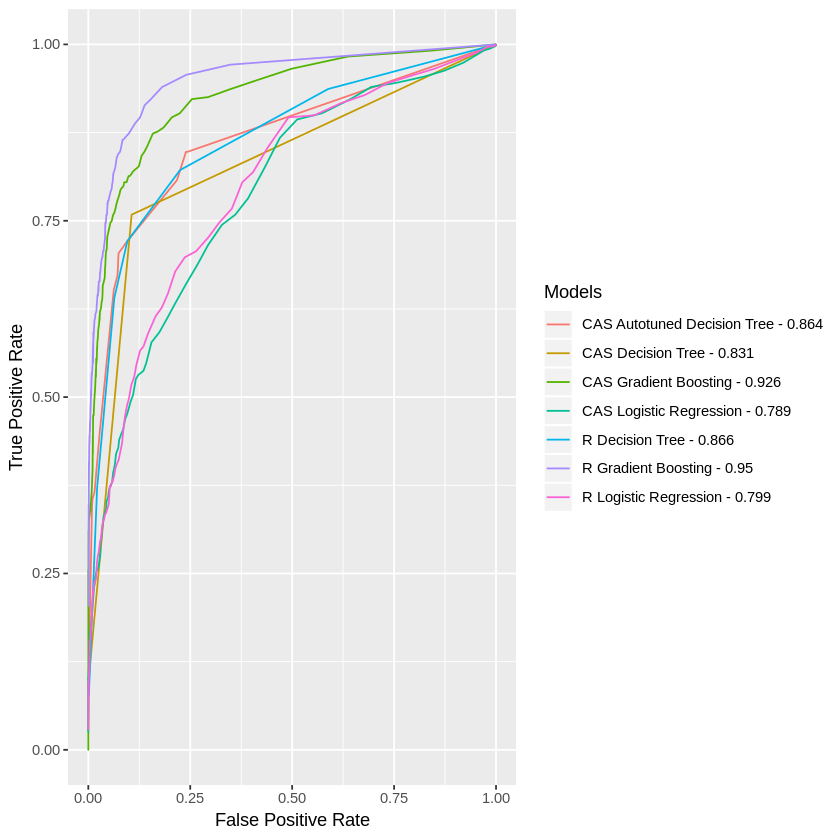

In [45]:
# Add a new column to be used as the ROC curve label
roc.df$Models <- paste(roc.df$Model, round(roc.df$C, 3), sep = ' - ')

# Create the ROC curve
ggplot(data = roc.df[c('FPR', 'Sensitivity', 'Models')],
    aes(x = as.numeric(FPR), y = as.numeric(Sensitivity), colour = Models)) +
    geom_line() +
    labs(x = 'False Positive Rate', y = 'True Positive Rate')

## End the session

In [46]:
# End the session
cas.session.endSession(conn)

list()

We have gone through an example of using SAS Viya with R for analysis. We connected to our CAS server, imported, explored, and cleaned our data, we built three models in R, three in CAS, and one autotuned model in CAS, and we ended by examining our model’s misclassification rates and ROC curves.  And ultimately, we learned how easy it is to leverage SAS and R using SWAT, allowing programmers to utilize the power of SAS Analytics from the language they are comfortable in. 